# Import Necessary Modules

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy

# Import Data to Pandas

In [6]:
# set file path
# path = r'path to csv'
path = r'EmailOffer.csv'

In [23]:
data = pd.read_csv(path, sep=',')
# make sure sep is set correctly
# add list of name parameters if parsing error due to rows having too many cols

In [12]:
# take a quick look to see if everything is okay
data.head()

,Age,Gender,TookAction
0,38,Female,0
1,32,Female,0
2,46,Male,1
3,34,Male,0
4,40,Male,0


In [16]:
# Get dummy variables
dGender = pd.get_dummies(data['Gender'], drop_first=True)

In [24]:
# Drop 'Gender' column from dataset and join with dummy variable 'dGender'
data = data.join(dGender)

   Age  Gender  TookAction  Male
0   38  Female           0     0
1   32  Female           0     0
2   46    Male           1     1
3   34    Male           0     1
4   40    Male           0     1


In [25]:
# Drop categorical 'Gender' column and reorder columns so dependent var is last
data = data[['Age', 'Gender', 'Male', 'TookAction']]

In [27]:
print(data.describe())

              Age        Male  TookAction
count  100.000000  100.000000  100.000000
mean    38.000000    0.500000    0.400000
std      7.247431    0.502519    0.492366
min     26.000000    0.000000    0.000000
25%     32.000000    0.000000    0.000000
50%     38.000000    0.500000    0.000000
75%     44.000000    1.000000    1.000000
max     50.000000    1.000000    1.000000


In [28]:
print(data.corr())

                 Age      Male  TookAction
Age         1.000000  0.000000    0.789763
Male        0.000000  1.000000    0.204124
TookAction  0.789763  0.204124    1.000000


# Modeling The Data

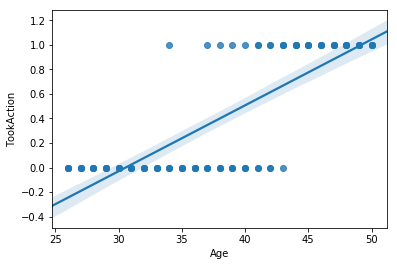

In [29]:
sns.regplot(data['Age'], data['TookAction'])

Wrong tool for the job, there is definitly some sort of skew, but it is not linear

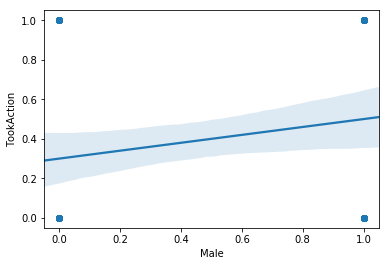

In [30]:
sns.regplot(data['Male'], data['TookAction'])

# Logistic Regression
  
Since the nature of the outcome is binary, a linear regression doesn't really make sense. What does it mean when the regression line is above 1 or below 0? Really nothing that has any tangible effect.<br>
Instead of a linear regression, I will model the data with a logistic regression. The regression line behaves as a cdf in so far as the line yield a probabilistic y-hat value.

In [144]:
f = 'TookAction ~ Age + Male'
smfResult = smf.logit(formula=str(f), data=data).fit()

Optimization terminated successfully.
         Current function value: 0.148067
         Iterations 10


In [145]:
smfResult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TookAction   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Thu, 07 Feb 2019   Pseudo R-squ.:                  0.7800
Time:                        14:59:14   Log-Likelihood:                -14.807
converged:                       True   LL-Null:                       -67.301
                                        LLR p-value:                 1.592e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -38.1520      9.987     -3.820      0.000     -57.726     -18.578
Age            0.8872      0.232      3.828      0.000       0.433       1.342
Male           4.4374      1.492      2.974      0.003       1.513       7.361
==============================================================================

Possibly complete quasi-separation: A fraction 0.22 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

coefficients can be used to compare magnitude PER UNIT across the different variables  
z = coef/std err

/Users/jdkrahulik/anaconda3/envs/conda_root/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


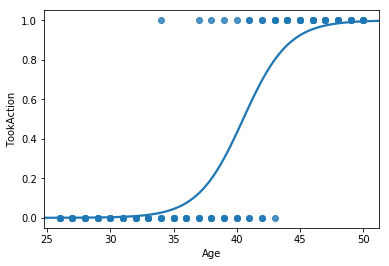

In [39]:
sns.regplot(data['Age'], data['TookAction'], ci=0, logistic=True)

# Modeling with SKLearn

In [49]:
from sklearn.linear_model import LogisticRegression

In [98]:
logRegr = LogisticRegression(solver='liblinear', multi_class='auto', C=1e5)
# setting parameters for classifier
# Since there are only two regressors and the data set isn't overly large, using 'liblinear' as solver
# and setting C to 10000

In [99]:
result = logRegr.fit(data[['Age', 'Male']], data['TookAction'])

In [63]:
data.head()

,Age,Gender,Male,TookAction
0,38,Female,0,0
1,32,Female,0,0
2,46,Male,1,1
3,34,Male,1,0
4,40,Male,1,0


In [100]:
result.predict_proba(data[['Age', 'Male']])[0:,0].shape

(100,)

In [107]:
# Merge dataframe with predicitons
resData = data.join(pd.DataFrame(result.predict_proba(data[['Age', 'Male']])[0:,1], columns=['Prob.'], dtype='object')).drop(columns='Male')
resData.head(10)

,Age,Gender,TookAction,Prob.
0,38,Female,0,0.0118092
1,32,Female,0,5.89742e-05
2,46,Male,1,0.99916
3,34,Male,0,0.0281703
4,40,Male,0,0.854512
5,37,Female,0,0.00490675
6,43,Male,1,0.988181
7,38,Male,1,0.499997
8,27,Male,0,5.9025e-05
9,42,Female,0,0.291916


In [113]:
pHat = resData['Prob.'].astype('float')
age  = data['Age'].astype('int')

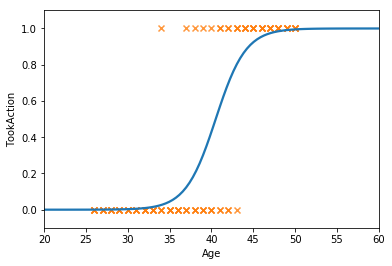

In [129]:
ax = plt.axis([20, 60, -0.1, 1.1])
sns.regplot(age, pHat, logistic=True, ci=0, scatter=False)
sns.regplot(age, data['TookAction'], fit_reg=False, marker='x')
plt.show()

# Making a Confusion Matrix

In [131]:
predictions = logRegr.predict(data[['Age','Male']])

In [132]:
from sklearn import metrics
cm = metrics.confusion_matrix(data['TookAction'], predictions)

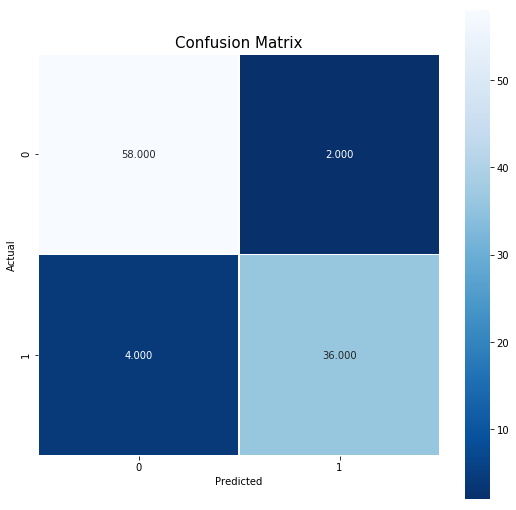

In [134]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual');
plt.xlabel('Predicted');
all_sample_title = 'Confusion Matrix'
plt.title(all_sample_title, size = 15);
plt.show()